# Testing LIME for visual explanations of model's predictions
This notebook can be used to perform LIME on one image for any of our 6 models.

In [229]:
# imports
import os
import random
import torch

import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision import datasets, transforms
from data_utils.data_stats import *
from utils.metrics import AverageMeter, topk_acc
from torchmetrics import Accuracy
from models.resnet import resnet18
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm
from models.networks import get_model

from skimage.measure import label
from skimage.color import label2rgb
import timm

from datasets import load_dataset

import cv2
from PIL import Image

In [232]:
# Hyperparameters
DATASET_NAME = "cifar10"  # one of: cifar10, tinyimagenet
MODEL_NAME = "mlp"  # one of: mlp, resnet, vit
DEVICE = "cpu"  # one of: cpu, cuda:0
BATCH_SIZE = 256

Execute for dataset selection

In [233]:
if DATASET_NAME == "cifar10":
    # CIFAR10 Dataset Configuration
    dataset_classes = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

    # Setup dataloader
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0)
elif DATASET_NAME == "tinyimagenet":
    # TinyImageNet Dataset Configuration
    dataset_classes = ['goldfish, Carassius auratus', 'European fire salamander, Salamandra salamandra', 'bullfrog, Rana catesbeiana', 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 'American alligator, Alligator mississipiensis', 'boa constrictor, Constrictor constrictor', 'trilobite', 'scorpion', 'black widow, Latrodectus mactans', 'tarantula', 'centipede', 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus', 'jellyfish', 'brain coral', 'snail', 'sea slug, nudibranch', 'American lobster, Northern lobster, Maine lobster, Homarus americanus', 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', 'black stork, Ciconia nigra', 'king penguin, Aptenodytes patagonica', 'albatross, mollymawk', 'dugong, Dugong dugon', 'Yorkshire terrier', 'golden retriever', 'Labrador retriever', 'German shepherd, German shepherd dog, German police dog, alsatian', 'standard poodle', 'tabby, tabby cat', 'Persian cat', 'Egyptian cat', 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'lion, king of beasts, Panthera leo', 'brown bear, bruin, Ursus arctos', 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle', 'grasshopper, hopper', 'walking stick, walkingstick, stick insect', 'cockroach, roach', 'mantis, mantid', "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk", 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus', 'sulphur butterfly, sulfur butterfly', 'sea cucumber, holothurian', 'guinea pig, Cavia cobaya', 'hog, pig, grunter, squealer, Sus scrofa', 'ox', 'bison', 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis', 'gazelle', 'Arabian camel, dromedary, Camelus dromedarius', 'orangutan, orang, orangutang, Pongo pygmaeus', 'chimpanzee, chimp, Pan troglodytes', 'baboon', 'African elephant, Loxodonta africana', 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens', 'abacus', "academic gown, academic robe, judge's robe", 'altar', 'backpack, back pack, knapsack, packsack, rucksack, haversack', 'bannister, banister, balustrade, balusters, handrail', 'barbershop', 'barn', 'barrel, cask', 'basketball', 'bathtub, bathing tub, bath, tub', 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon', 'beacon, lighthouse, beacon light, pharos', 'beaker', 'beer bottle', 'bikini, two-piece', 'binoculars, field glasses, opera glasses', 'birdhouse', 'bow tie, bow-tie, bowtie', 'brass, memorial tablet, plaque', 'bucket, pail', 'bullet train, bullet', 'butcher shop, meat market', 'candle, taper, wax light', 'cannon', 'cardigan', 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM', 'CD player', 'chest', 'Christmas stocking', 'cliff dwelling', 'computer keyboard, keypad', 'confectionery, confectionary, candy store', 'convertible', 'crane', 'dam, dike, dyke', 'desk', 'dining table, board', 'dumbbell', 'flagpole, flagstaff', 'fly', 'fountain', 'freight car', 'frying pan, frypan, skillet', 'fur coat', 'gasmask, respirator, gas helmet', 'go-kart', 'gondola', 'hourglass', 'iPod', 'jinrikisha, ricksha, rickshaw', 'kimono', 'lampshade, lamp shade', 'lawn mower, mower', 'lifeboat', 'limousine, limo', 'magnetic compass', 'maypole', 'military uniform', 'miniskirt, mini', 'moving van', 'neck brace', 'obelisk', 'oboe, hautboy, hautbois', 'organ, pipe organ', 'parking meter', 'pay-phone, pay-station', 'picket fence, paling', 'pill bottle', "plunger, plumber's helper", 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria', 'poncho', 'pop bottle, soda bottle', "potter's wheel", 'projectile, missile', 'punching bag, punch bag, punching ball, punchball', 'refrigerator, icebox', 'remote control, remote', 'rocking chair, rocker', 'rugby ball', 'sandal', 'school bus', 'scoreboard', 'sewing machine', 'snorkel', 'sock', 'sombrero', 'space heater', "spider web, spider's web", 'sports car, sport car', 'steel arch bridge', 'stopwatch, stop watch', 'sunglasses, dark glasses, shades', 'suspension bridge', 'swimming trunks, bathing trunks', 'syringe', 'teapot', 'teddy, teddy bear', 'thatch, thatched roof', 'torch', 'tractor', 'triumphal arch', 'trolleybus, trolley coach, trackless trolley', 'turnstile', 'umbrella', 'vestment', 'viaduct', 'volleyball', 'water jug', 'water tower', 'wok', 'wooden spoon', 'comic book', 'reel', 'guacamole', 'ice cream, icecream', 'ice lolly, lolly, lollipop, popsicle', 'goose', 'drumstick', 'plate', 'pretzel', 'mashed potato', 'cauliflower', 'bell pepper', 'lemon', 'banana', 'pomegranate', 'meat loaf, meatloaf', 'pizza, pizza pie', 'potpie', 'espresso', 'bee', 'apron', 'pole', 'Chihuahua', 'alp', 'cliff, drop, drop-off', 'coral reef', 'lakeside, lakeshore', 'seashore, coast, seacoast, sea-coast', 'acorn', 'broom', 'mushroom', 'nail', 'chain', 'slug', 'orange']
    dataset = load_dataset('Maysee/tiny-imagenet', split='valid')

    transform_test = transforms.ToTensor()

    def collate_fn_test(batch):
        return ((torch.stack([transform_test(Image.fromarray(cv2.cvtColor(np.array(x['image']),cv2.COLOR_GRAY2RGB))) if np.array(x['image']).ndim == 2 else transform_test(x['image']) for x in batch])), torch.tensor([x['label'] for x in batch]))

    data_loader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, 
                                              num_workers=0, 
                                              collate_fn=collate_fn_test)
else:
    raise ValueError("Dataset is not registered!")

num_classes = CLASS_DICT[DATASET_NAME]
assert len(dataset_classes) == num_classes

mean = MEAN_DICT[DATASET_NAME]
std = STD_DICT[DATASET_NAME]

input_transform = transforms.Normalize(mean / 255., std / 255.)

torch.backends.cuda.matmul.allow_tf32 = True

Files already downloaded and verified


Execute to select architecture.

In [234]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model, input_size):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.resize = transforms.Resize(input_size)

    def forward(self, x):
        x = self.resize(x)
        x = self.model(x)
        return x

class MLPWrapper(torch.nn.Module):
    def __init__(self, model, input_size):
        super(MLPWrapper, self).__init__()
        self.model = model
        self.resize = transforms.Resize(input_size)

    def forward(self, x):
        x = self.resize(x)
        x = x.flatten(1)
        x = self.model(x)
        return x

if not os.path.exists("checkpoints"):
        os.mkdir("checkpoints")

In [235]:
if DATASET_NAME == "cifar10" and MODEL_NAME == "resnet":
    # ResNet CIFAR10
    model = resnet18(pretrained=True)
elif DATASET_NAME == "tinyimagenet" and MODEL_NAME == "resnet":
    # ResNet TinyImageNet
    resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, 200)

    model_full_path = "./models/resnet18_tinyimagenet.pt"
    checkpoint = torch.load(model_full_path, map_location=torch.device(DEVICE))

    resnet_model = torch.nn.DataParallel(resnet_model)
    resnet_model.load_state_dict(checkpoint['model'])

    model = ModelWrapper(resnet_model, 224)
elif DATASET_NAME == "cifar10" and MODEL_NAME == "mlp":
    # MLP CIFAR10
    mlp_architecture = 'B_12-Wi_1024'  # B_12-Wi_512
    mlp_resolution = 64  # Resolution of fine-tuned model (64 for all models we provide)
    mlp_checkpoint = 'in21k_cifar10'  # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10
    mlp_model = get_model(architecture=mlp_architecture, resolution=mlp_resolution, num_classes=num_classes,
                          checkpoint=mlp_checkpoint)
    model = MLPWrapper(mlp_model, mlp_resolution)
elif DATASET_NAME == "tinyimagenet" and MODEL_NAME == "mlp":
    # MLP TinyImageNet
    mlp_architecture = 'B_12-Wi_1024'
    mlp_resolution = 64
    checkpoint = 'in21k_imagenet'

    # bypass
    model_mlp = get_model(architecture=mlp_architecture, resolution=mlp_resolution, num_classes=1000, checkpoint=checkpoint)
    model_mlp.linear_out = torch.nn.Linear(1024, num_classes)

    model_full_path = "./models/mlp_tinyimagenet.pt"
    checkpoint = torch.load(model_full_path, map_location=torch.device(DEVICE))

    model_mlp = torch.nn.DataParallel(model_mlp)
    model_mlp.load_state_dict(checkpoint['model'])
    model = MLPWrapper(model_mlp, mlp_resolution)
elif DATASET_NAME == "cifar10" and MODEL_NAME == "vit":
    # ViT CIFAR10
    vit_checkpoint = "./models/ViT_cifar10.pt"
    input_size = 224
    checkpoint = torch.load(vit_checkpoint, map_location=torch.device(DEVICE))
    vit_model = timm.create_model("vit_tiny_patch16_224", pretrained=True)
    vit_model.head = torch.nn.Linear(vit_model.head.in_features, num_classes)
    vit_model = torch.nn.DataParallel(vit_model) # make parallel
    vit_model.load_state_dict(checkpoint['model'])

    model = ModelWrapper(vit_model, input_size)
elif DATASET_NAME == "tinyimagenet" and MODEL_NAME == "vit":
    # ViT TinyImageNet
    vit_checkpoint = "./models/ViT_tinyimagenet.pt"
    input_size = 224
    checkpoint = torch.load(vit_checkpoint, map_location=torch.device(DEVICE))

    vit_model = timm.create_model("vit_tiny_patch16_224", pretrained=True)
    vit_model.head = torch.nn.Linear(vit_model.head.in_features, num_classes)
    vit_model = torch.nn.DataParallel(vit_model) # make parallel
    vit_model.load_state_dict(checkpoint['model'])

    model = ModelWrapper(vit_model, input_size)
else:
    raise ValueError("Unknown dataset / model combination!")

Weights already downloaded
Load_state output <All keys matched successfully>


In [207]:
# check model accuracy (sanity check), no need to execute
model.eval()
total_acc = AverageMeter()
accuracy = Accuracy(task="multiclass", num_classes=num_classes)

with torch.no_grad():
    for ims, targs in tqdm(data_loader, desc="Evaluation"):
        preds = model(input_transform(ims))
        acc, _ = topk_acc(preds, targs, k=1, avg=True)
        total_acc.update(acc, ims.shape[0])

print("Model Accuracy: %2.2f %%" % total_acc.get_avg(percentage=True))

Evaluation: 100%|██████████| 40/40 [09:52<00:00, 14.81s/it]

Model Accuracy: 73.21 %


In [236]:
# get random image
def get_random_image():
    image_nr = None
    if DATASET_NAME == "cifar10":
        image_nr = random.randrange(len(dataset))  # random image
        # image_nr = 9297  # specific image id

        image, true_label = dataset[image_nr]
    elif DATASET_NAME == "tinyimagenet":
        random_batch = next(iter(data_loader))
        image, true_label = random_batch[0][0], random_batch[1][0]
    
    image_np = image.numpy().transpose((1, 2, 0))
    plt.imshow(image_np)
    plt.show()
    
    print(f"Picked image {image_nr or ''} with true label '{dataset_classes[true_label]}'.")
    
    return image, true_label

# reshape to get input tensor for a particular image
def get_input_tensor(img):
    img = input_transform(img).unsqueeze(0)
    return img

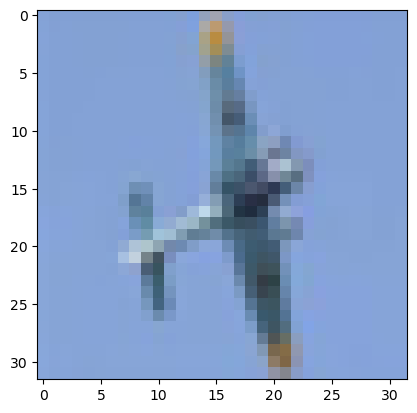

Picked image 1973 with true label 'airplane'.
Predicted 'airplane' with probability 68.89%'


In [242]:
# prediction of our model
model.eval()

with torch.no_grad():
    img, true_label = get_random_image() # 4136, 6358, 4073, 4991, 9297, 6058
    output = model(get_input_tensor(img))
    probabilities = torch.nn.functional.softmax(output, dim=-1).squeeze()
    predicted_class = torch.argmax(probabilities).item()

    predicted_label = dataset_classes[predicted_class]
    
    print(f"Predicted '{predicted_label}' with probability {(probabilities[predicted_class] * 100):.2f}%'")

In [244]:
lime_transform = transforms.Compose([
    transforms.ToTensor(),
    input_transform
])
def batch_predict(images):
    model.eval()
    
    batch = torch.stack([lime_transform(i) for i in images])
    # batch = torch.reshape(batch, (batch.shape[0], -1))  # enable if MLP
    
    # pick random sample from batch and perform classification
    random_idx = random.randrange(len(images))
    plt.imshow(images[random_idx])
    plt.show()
    
    sample_logits = model(batch[random_idx].unsqueeze(0))
    sample_probs = torch.nn.functional.softmax(sample_logits, dim=-1).squeeze()
    sample_class = torch.argmax(sample_probs).item()
    sample_label = dataset_classes[sample_class]
    print(f"Predicted '{sample_label}' with probability {(sample_probs[sample_class] * 100):.2f}%'")

    with torch.no_grad():
        logits = model(batch)
        probs = torch.nn.functional.softmax(logits, dim=-1).numpy()
        return probs

In the next stage, we will perform LIME analyzis on the random image.
The parameters can be adjusted:
- top_labels: selects the K topmost predicted classes to perform the analysis
- hide_color: if not specified, avg of segment is used to mask out part of the image
- segmentation_fn: which segmentation algorithm to be used
- num_samples: number of images that will be classified

Here we can certainly play around with the **segmentation algorithm** and hyperparameters thereof.<br>
Default is quickshift(kernel_size=4, max_dist=200, ratio=0.2)

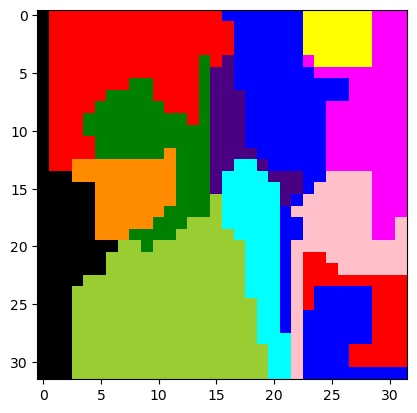

In [245]:
# specify segmentation algorithm

# segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)  # default
segmentation_fn = SegmentationAlgorithm('felzenszwalb', scale=1, sigma=.8)
segmentation_mask = segmentation_fn(img.numpy().transpose(1, 2, 0))

# can specify image=img.numpy().transpose(1, 2, 0) to get overlay
image_label_overlay = label2rgb(segmentation_mask, image=None, bg_label=0, alpha=0.1)

# visualize segmentation
plt.imshow(image_label_overlay)

  0%|          | 0/100 [00:00<?, ?it/s]

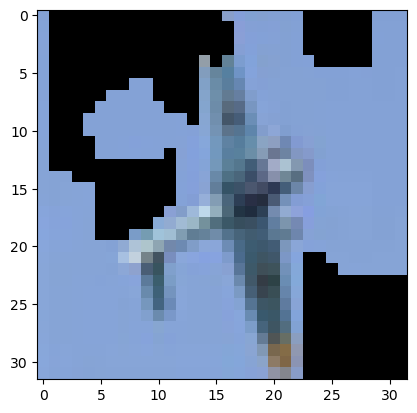

Predicted 'deer' with probability 77.73%'


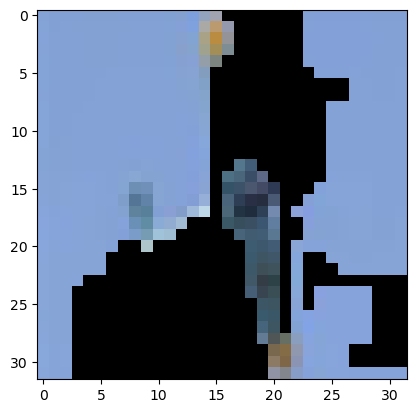

Predicted 'deer' with probability 42.51%'


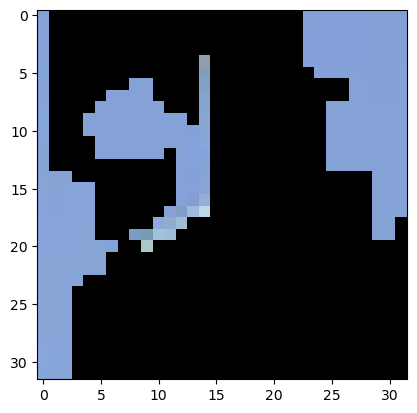

Predicted 'deer' with probability 59.99%'


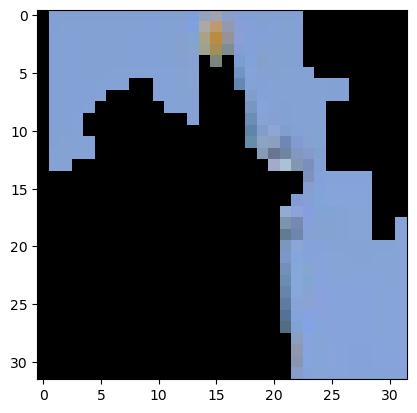

Predicted 'deer' with probability 30.77%'


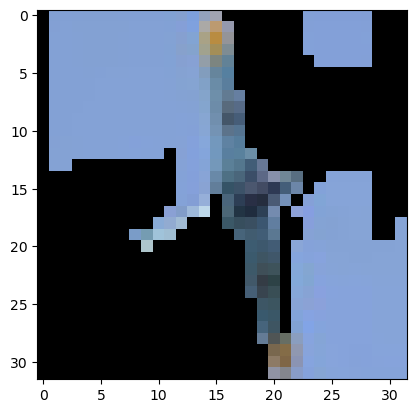

Predicted 'deer' with probability 73.64%'


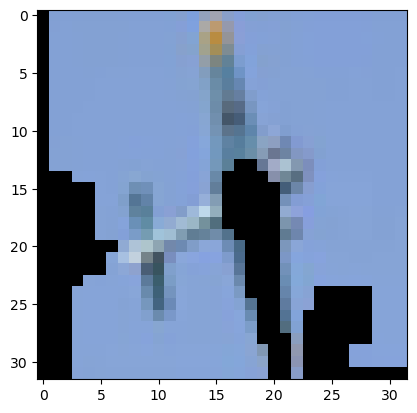

Predicted 'bird' with probability 49.33%'


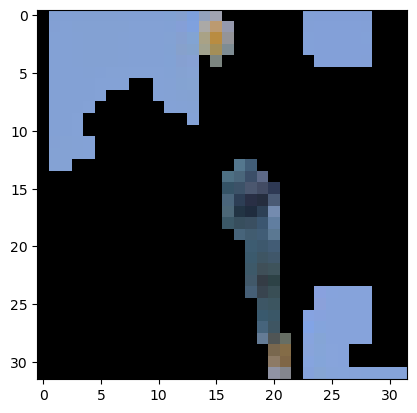

Predicted 'deer' with probability 47.48%'


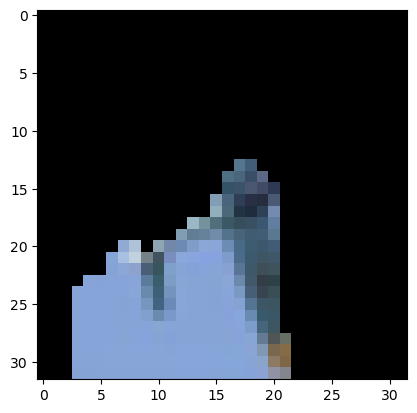

Predicted 'horse' with probability 29.60%'


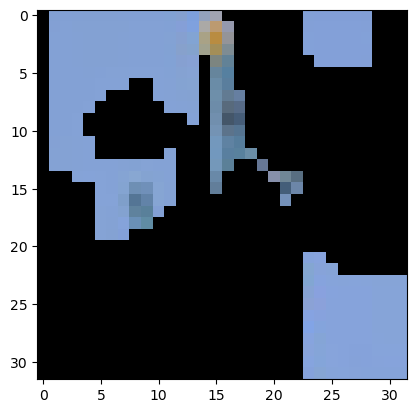

Predicted 'deer' with probability 69.51%'


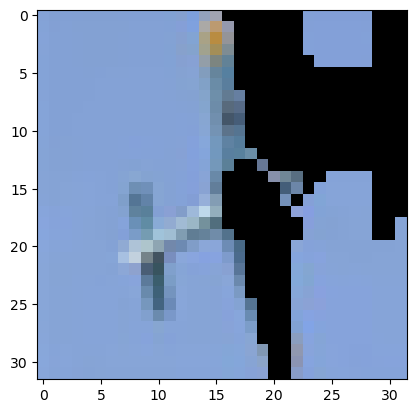

Predicted 'cat' with probability 36.92%'


In [246]:
# Perform LIME operations
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img.numpy().transpose(1, 2, 0), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0,
                                         segmentation_fn=segmentation_fn,
                                         num_samples=100) # number of images that will be sent to classification

The next two cells show the results. The parameters are:
- positive_only: only show the areas (segments) that correlate with the top label
- num_features: somehow indicates the size of the correlated area
- hide_rest: whether the unnecessary parts of the image should be masked out

Here, one can certainly play around with the **num_features** parameter

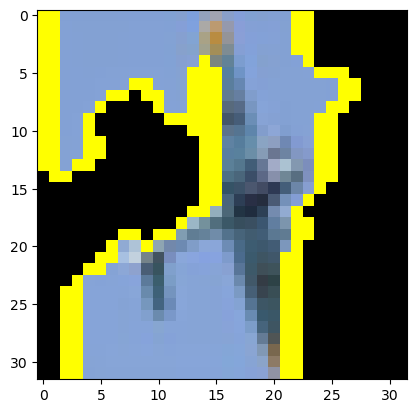

In [247]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry = mark_boundaries(temp, mask)
plt.imshow(img_boundry)

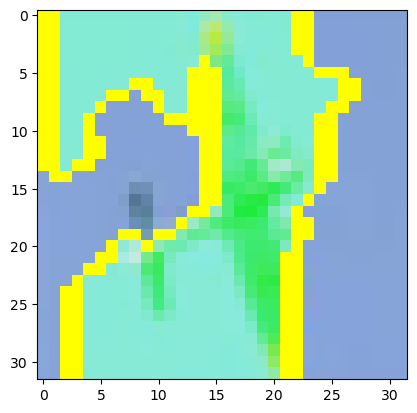

In [248]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry = mark_boundaries(temp, mask)
plt.imshow(img_boundry)